In [1]:
# only used for the Jupyter Notebook version:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#display(HTML("<style>.container { width:60% !important; }</style>"))
#display(HTML("<style>.container { width:42% !important; }</style>"))
# max line length (79)
###############################################################################
# max comments/doc strings line length (72)
########################################################################

import spectrum
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sg
from scipy.stats import chi2
from scipy.special import digamma
import xarray as xr

# ignoring warnings for a couple of specific future code changes
import warnings

#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Define the paths to the data

In [2]:
outdir = 'C:/Users/HoldenJe/Drift/jupyter_notebooks/rotary_spectra/output/'
jupyterdir = 'C:/Users/HoldenJe/Drift/jupyter_notebooks/'
    
projdir = os.path.join(jupyterdir, 'rotary_spectra/input/nancys_sample_data/')
projdir_reduced = os.path.join(jupyterdir, 'rotary_spectra/input/nancys_sample_data/reduced/')

ciopse = os.path.join(projdir, 'ciopse_bc12_plus/output_per_drifter')
ciopse_filter = os.path.join(projdir, ('ciopse_bc12_plus_filter_30x30/output_per_drifter/'))
#datadir = os.path.join(projdir, ('CIOPSEBC12PLUS-CIOPSEBC12PLUSFILTER30/'))

ciopse_files = glob.glob(os.path.join(ciopse,'*.nc'))
ciopse_files.sort()

ciopse_files_filter = glob.glob(os.path.join(ciopse_filter,'*.nc'))
ciopse_files_filter.sort()

label_map = {'CIOPSEBC12PLUS': 'CIOPSE',
             'CIOPSEBC12PLUSFILTER30': 'CIOPSE-filter75km'}

### Some functions that are common to multiple plots

In [3]:
#define functions to return the Coriolis and tidal frequencies
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
    lat : str
        Latitude in degrees
        
    Returns
    -------
    The Coriolis frequecy at latitude lat
    """    
    omega = 7.2921159e-5;
    return 2 * np.sin(lat * 2 * np.pi / 360) * omega * (3600) * 24;


#define functions to return the Coriolis and tidal frequencies
def corfreq_range(d, lats=['mean', 'min', 'max']):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
    d : xr.DataSet
        dataset containing latitude values
    lats : list
        list of strings defining which frequencies will be 
        returned in the array
        
    Returns
    -------
    An np array containg Coriolis frequecy at chosen latitudes
    """    
    
    freqdict = {'mean': corfreq(d.lat.values.mean()) / 2 / np.pi, 
                'min': corfreq(d.lat.values.min()) / 2 / np.pi, 
                'max':corfreq(d.lat.values.max()) / 2 / np.pi}
    
    return np.array([freqdict[l] for l in lats])


def tidefreq():
    """ Returns an array of eight major tidal frequencies in rad / day.  
    See Gill (1982) page 335. """    
    return 24 * 2 * np.pi / np.array([327.85, 25.8194, 24.0659, 23.9344, 
                                      12.6584, 12.4206, 12.0000, 11.9673])


def mconf(K, gamma, str):
    """ Compute symmetric confidence intervals for multitaper 
    spectral estimation.
    
    Parameters
    ----------
    K : float 
        Number of tapers used in the spectral estimate, normally 2*P-1
    gamma : float 
        confidence level, e.g., 0.95
    str : str
        'lin' to return confidence intervals for linear axis 
        'log' to return confidence intervals for log10 axis 
    
    Returns
    -------
    ra, rb:  Ratio factors for confidence interval
        
    If S0 is the true value of the spectrum and S is the spectral estimate,
    then the confindence interval is defined such that 
    
        Probability that ra < S/S0 < ra = gamma     (linear case)
        Probability that ra < log10(S)/log10(S0) < ra = gamma (log10 case)

    The confidence interval will be S*ra to S*rb for the spectral values
    in linear space, or S*10^ra to S*10^rb in log10 space.  If log10(S) 
    is plotted rather than S with a logarithmic axis, the latter would 
    become log10(S) + ra to log10(S) * rb.    
    """

    dx=0.0001
    
    # Compute pdf symmetrically about unity
    if str=='lin':
    
        # from one to minus one
        x1 = np.arange(1 - dx / 2, -1, step=-dx) * 2 * K
        # from 1 to three
        x2 = np.arange(1 + dx / 2, 3 ,step=dx) * 2 * K  
        fx = (chi2.pdf(x1, 2 * K) + chi2.pdf(x2, 2 * K)) * 2 * K
        sumfx = np.cumsum(fx) * dx

        ii = np.where(sumfx >= gamma)[0][0]
        ra = x1[ii] / 2 / K
        rb = x1[ii] / 2 / K
    
    elif str == 'log':
        
        xo = np.log(2) + np.log(1 / 2 / K) + digamma(K) #see pav15-arxiv
        c = np.log(10)
        xo = xo / c  #change of base rule
    
        x1 = np.power(10, np.arange(xo - dx / 2, xo - 2, step=-dx))   
        x2 = np.power(10, np.arange(xo + dx / 2, xo + 2, step = dx))  
    
        fx1 = c * 2 * K * np.multiply(x1, chi2.pdf(2 * K * x1, 2 * K))
        fx2 = c * 2 * K * np.multiply(x2, chi2.pdf(2 * K * x2, 2 * K))

        sumfx = np.cumsum(fx1 + fx2) * dx
    
        ii = np.where(sumfx >= gamma)[0][0]
        ra = np.log10(x1[ii])
        rb = np.log10(x2[ii])
    
    return ra, rb    


def concat_outputs(dconcat, buoyid=None):
    """ """
    setnames = [d.setname.values[0] for d in dconcat]
    dcombine = xr.concat(dconcat, pd.Index(setnames, name='setname'))
    dcombine.dropna(dim='time')
    return dcombine    


def process_datasets(files):
    """ """
    datadict = {}
    for f in files:
        d = xr.open_dataset(f)
        if 'setname' not in list(d.dims.keys()):
            sname = [d.setname if 'setname' in d.keys() 
                     else d.ocean_model_name][0]
            d = d.assign_coords(setname=sname)
            d = d.expand_dims('setname')

        buoydict = {'buoyid': d.obs_buoyid,
                    'ds': d, 
                    'filename': f,
                    'setname': d.setname.values[0]}
        datadict[d.obs_buoyid] = buoydict
        
    return datadict


def create_cvdict(d):
    """ """
    # build complex velocities
    cv_obs = d.isel(setname=0).ueast_drifter.values + 1j * d.isel(setname=0).vnorth_drifter.values
    cvdict = {'Observations': cv_obs}
    setnames = list(d.setname.values)
    
    for sind in range(0, len(setnames)):
        dsel = d.isel(setname=sind)
        cvdict[str(setnames[sind])] = dsel.ueast_ocean.values + 1j * dsel.vnorth_ocean.values
    return cvdict


def add_reference_lines(ax, d, tidal=True, coriolis=True, cori_lats=['mean', 'min', 'max']):
    """ """
    if tidal:
        # add reference lines for major tidal frequencies
        tcount = 0
        for tidal_freq in tidefreq() / 2 / np.pi:
            tlab = 'Tidal Frequencies'
            if tcount > 0:
                tlab = '__nolabel'
            tcount += 1
            ax.axvline(tidal_freq, 
                       linestyle="--", 
                       color="gray",
                       linewidth=1,
                       label=tlab)

    if coriolis:
        # add reference lines for the Coriolas freq 
        # at min, max, and mean latitudes
        ccount = 0
        for coriolis_freq in corfreq_range(d, cori_lats):
            clab = 'Coriolis Frequency at\nmean latitude'
            if ccount > 0:
                clab = '__nolabel'
            ccount += 1
            ax.axvline(coriolis_freq,
                       color="black",
                       linewidth=1,
                       label=clab)


def calc_rotary_spectrum(cv, dt, P=4):
    """Calculate rotary spectrum using mulit taper method with P tapers
    http://www.jmlilly.net/course/labs/html/SpectralAnalysis-Python.html"""

    psi, eigs = spectrum.mtm.dpss(np.size(cv), NW=P, k=2 * P - 1)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f, _ = sg.periodogram(cv - np.mean(cv), fs=1 / dt)

    Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv - np.mean(cv), 
                                                 k=2 * P - 1,  
                                                 NFFT=np.size(cv), 
                                                 v=psi, 
                                                 e=eigs, 
                                                 method="unity")

    S = np.mean(np.transpose(np.abs(Zk) ** 2), axis=1) * dt
        
    #to compute adaptive version just FYI
    #Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv-np.mean(cv), 
    #                                             k=2*P-1,  
    #                                             NFFT=np.size(cv), 
    #                                             v=psi, 
    #                                             e=eigs, 
    #                                             method="adapt");
    #S=np.mean(np.transpose(np.abs(Zk)**2) * weights, axis=1) * dt

    return f, S


def add_smoothing_lines(ax, f, P):
    """ """
    io=(1, 50, 200, 800)
    yo=(10 ** -2, 10 ** -3, 10 ** 0, 10 ** -5)

    plt.sca(ax)
    for i in range(np.size(io)):
        if i==0:
            plt.hlines(yo[i], f[io[i]], f[io[i] + P], linewidth=3, color='k')
        else:
            plt.hlines(yo[i], f[io[i] - P], f[io[i] + P], linewidth=3, color='k')
            
            
def plot_rotary_spectrum_posneg(f, S, axP, axN, label, c=None, P=None):
    """Plot the rotary sepctrum: positve frequencies on axP 
    and negative frequencies on axN"""
    #plot negative side
    axN.loglog(-f[np.where(f < 0)], 
               S[np.where(f < 0)], 
               color=c, label=label)
    #axN.invert_xaxis()
    axN.set_ylabel('Power Spectral Density (m$^2$/s$^2$ days)')
    axN.set_xlabel('Negative Frequency (cycles/day)')

    #plot positive side
    axP.loglog(f[np.where(f > 0)], 
               S[np.where(f > 0)], 
               color=c, label=label)
    axP.autoscale(enable=True, tight=True)
    axP.set_xlabel('Positive Frequency (cycles/day)')
    
    # add confidence intervals if required.
    if P:
        ra,rb = mconf(2 * P - 1, 0.95, 'log')
        for r, lab in zip([ra, rb], ['__nolabel', 'confidence intervals']):
            axN.loglog(-f[np.where(f < 0)], 
                       (10 ** r) * S[np.where(f < 0)], 
                       color=(0.8, 0.8, 0.8), 
                       linewidth=0.75, label=lab)
            axP.loglog(f[np.where(f > 0)], 
                       (10 ** r) * S[np.where(f > 0)], 
                       color=(0.8, 0.8, 0.8), 
                       linewidth=0.75, label=lab)

### Plot rotary spectrum

In [4]:
def plot_rotary_spectrum(d, P=4):
    
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    axN = axs[0]
    axP = axs[1]
    
    d = d.dropna(dim='time')
    cvdict = create_cvdict(d)
    cvs = [cvdict[n] for n in list(cvdict.keys())]
    dt = (d.time[1] - d.time[0]).values / np.timedelta64(1, 'D')
    names = list(cvdict.keys())
    colors = ['black'] + [None] * (len(names)-1)
    
    for setname, cv, c in zip(names, cvs, colors):
        f, S = calc_rotary_spectrum(cv, dt, P=P)
        plot_rotary_spectrum_posneg(f, S, axP, axN, setname, c=c)

    # add reference lines 
    for ax in [axN, axP]:
        ax.autoscale(enable=True, tight=True)
        add_reference_lines(ax, d, cori_lats=['mean'])
        ax.grid()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, 
               labels, 
               loc='center left', 
               bbox_to_anchor=(1, 0.5), 
               frameon=False, 
               title=(str(d.obs_buoyid) + ' (P = ' + str(P) + ')\n'))
    
    axN.invert_xaxis()
    
    fig.tight_layout(h_pad=2, w_pad=2)

    savestr = ('rotary_spectra_' + str(d.obs_buoyid) + '_P' + str(P) 
               + '_' + str(len(d.setname.values)) + '.png')
    plt.savefig(os.path.join(outdir, savestr))
    plt.show()
    plt.close()

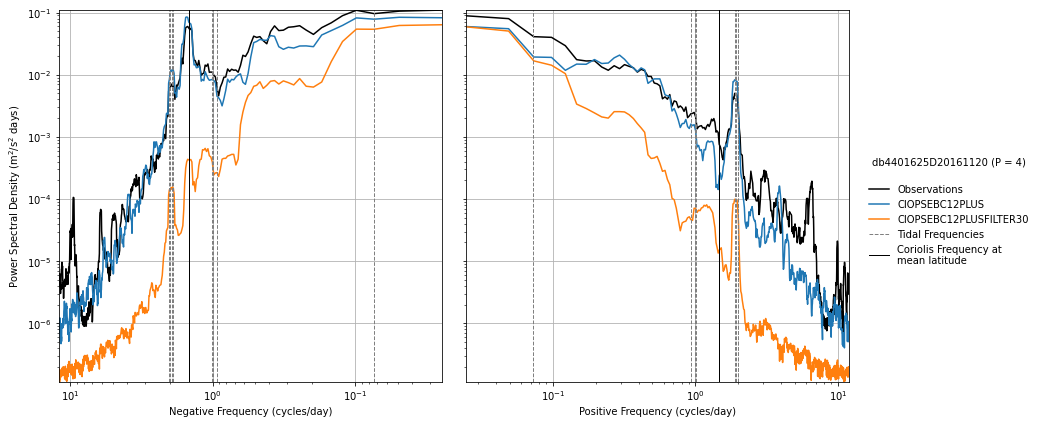

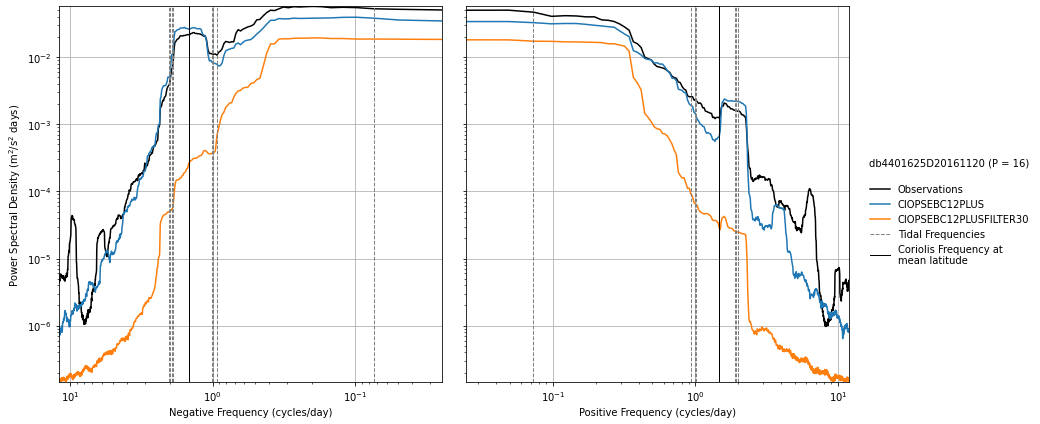

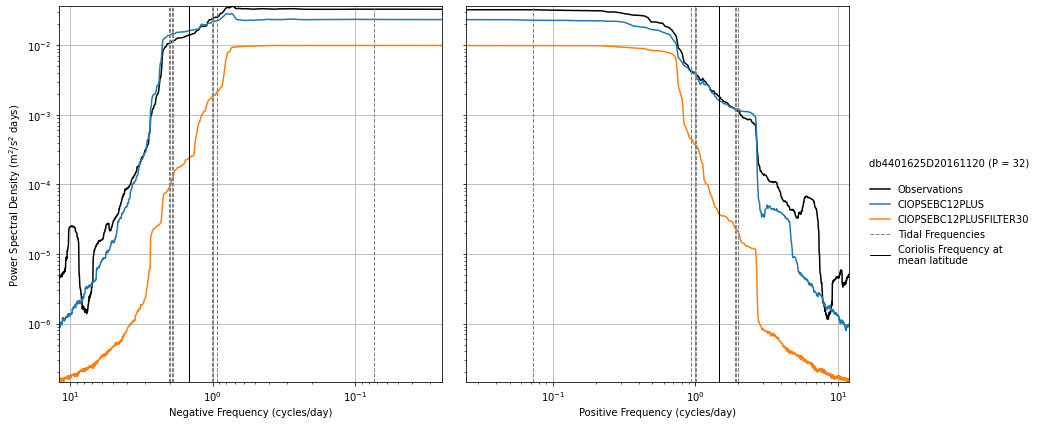

In [5]:
############################################################################
# Example with multiple datasets comparison:
############################################################################
sampleid = 'db4401625D20161120'
datadict = process_datasets(ciopse_files)
datadict_filtered = process_datasets(ciopse_files_filter)
buoyids = datadict.keys()
for buoyid in buoyids:    
    if sampleid not in buoyid:
        continue
    dcombine = concat_outputs([datadict[buoyid]['ds'], datadict_filtered[buoyid]['ds']])
    for p in [4, 16, 32]:
        plot_rotary_spectrum(dcombine, P=p)
        
        # to run with a single dataset:
        #plot_rotary_spectrum(datadict[buoyid]['ds'], P=p)

### plot multi taper

In [6]:
def plot_multi_taper(d, outdir, P=4):
    
    d = d.dropna(dim='time')
    dt = (d.time[1] - d.time[0]).values / np.timedelta64(1,'D')
    cvdict = create_cvdict(d)
    names = list(cvdict.keys())
    cvs = [cvdict[n] for n in names]
    
    # create a plot for each dataset
    for name, cv in zip(names, cvs):
        
        f, S = calc_rotary_spectrum(cv, dt, P=4)
        fig, ax = plt.subplots(1, 1)
        
        # plot positive side
        ax.loglog(f[np.where(f > 0)], S[np.where(f > 0)], label='Positive Spectrum')  
        
        # plot negative side
        ax.loglog(-f[np.where(f < 0)], S[np.where(f < 0)], label='Negative Spectrum')  
        
        # add reference lines 
        add_reference_lines(ax, d, cori_lats=['mean'])
        
        # show smoothing extents at different frequencies
        add_smoothing_lines(ax, f, P)

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, 
                   labels, 
                   loc='center left', 
                   bbox_to_anchor=(1, 0.5), 
                   frameon=False, 
                   title=(str(d.obs_buoyid) + ' (P=' + str(P) + ')' + '\n'))
        
        ax.autoscale(enable=True, tight=True)
        ax.grid()
        fig.tight_layout(h_pad=2, w_pad=2)
        plt.xlabel('Frequency (cycles/day)')
        plt.ylabel('Power Spectral Density (m$^2$/s$^2$ days)')
        plt.title('Multitaper Rotary Spectral Estimate (' + str(name) + ')');

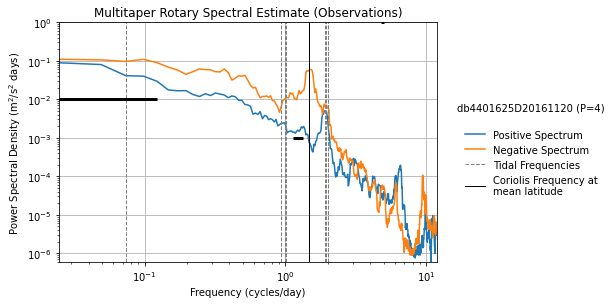

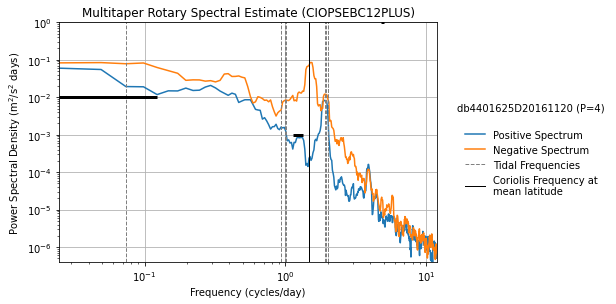

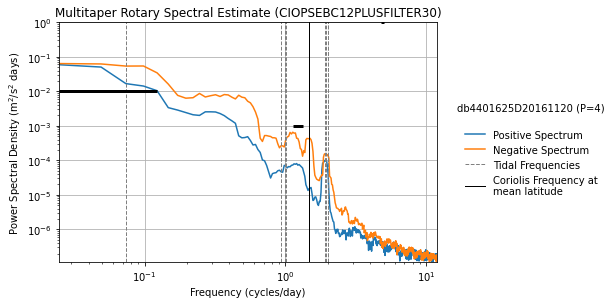

In [13]:
############################################################################
# Example with multiple datasets comparison:
############################################################################
#sampleid = 'db1300602D20161030' # doesn't work?
# this seems to fail when looking at smoothing extents at different frequencies
sampleid = 'db4401625D20161120'
datadict = process_datasets(ciopse_files)
datadict_filtered = process_datasets(ciopse_files_filter)
buoyids = datadict.keys()
for buoyid in buoyids:
    if sampleid not in buoyid:
        continue
    dcombine = concat_outputs([datadict[buoyid]['ds'], datadict_filtered[buoyid]['ds']])
    plot_multi_taper(dcombine, outdir)
    
    # to run with a single dataset:
    #plot_multi_taper(datadict[buoyid]['ds'], outdir)

### plot multi taper with confidence intervals

In [8]:
def plot_multi_taper_with_sym_confidence_intervals(d, outdir, P=4):
    
    d = d.dropna(dim='time')
    dt = (d.time[1] - d.time[0]).values / np.timedelta64(1,'D')
    cvdict = create_cvdict(d)
    names = list(cvdict.keys())
    cvs = [cvdict[n] for n in names]
    
    for name, cv, c in zip(names, cvs, [None] * (len(names))):
        f, S = calc_rotary_spectrum(cv, dt, P=4)
        
        fig, ax = plt.subplots(1, 2,sharey=True,figsize=(12,6))
        plot_rotary_spectrum_posneg(f, S, ax[1], ax[0], name, c=c, P=P)
        
        for n in range(np.size(ax)):
            ax[n].autoscale(enable=True, tight=True) 
            #show smoothing extents at different frequencies
            add_smoothing_lines(ax[n], f, P)
            ax[n].grid()
        
        handles, labels = ax[0].get_legend_handles_labels()
        fig.legend(handles,
                   #reversed(handles),
                   labels,
                   #reversed(labels),
                   loc='center left', 
                   bbox_to_anchor=(1, 0.5), 
                   frameon=False, 
                   title=(str(d.obs_buoyid) + ' (P=' + str(P) + ')' + '\n'))
        
        ax[0].invert_xaxis()
        fig.tight_layout(h_pad=2, w_pad=2)
        fig.suptitle('Multitaper Rotary Spectral Estimate (' + str(name) + ')', y=1.01);
        plt.savefig(os.path.join(outdir, ('multitaper_with_conf_' + str(d.obs_buoyid) + '_' + str(P) + '.png')))

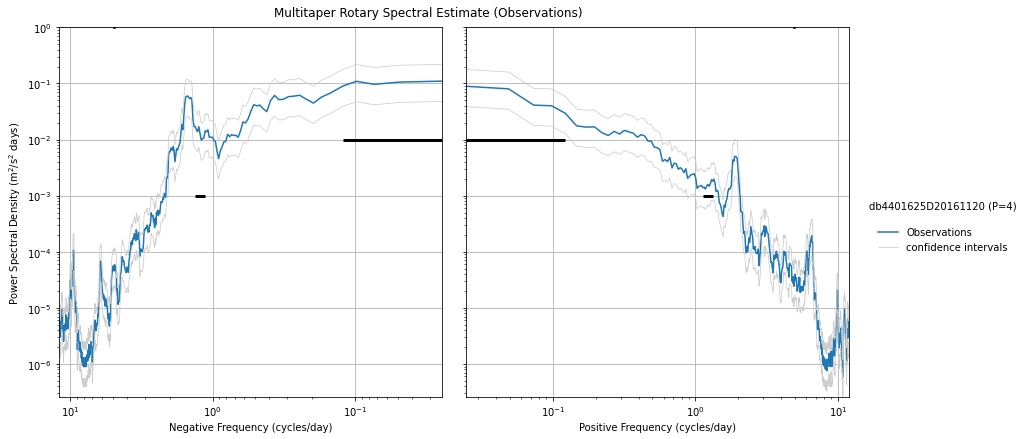

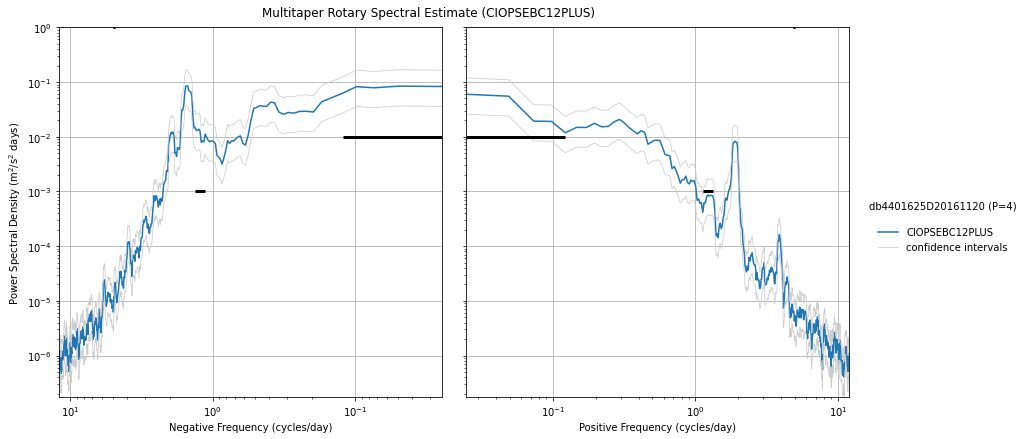

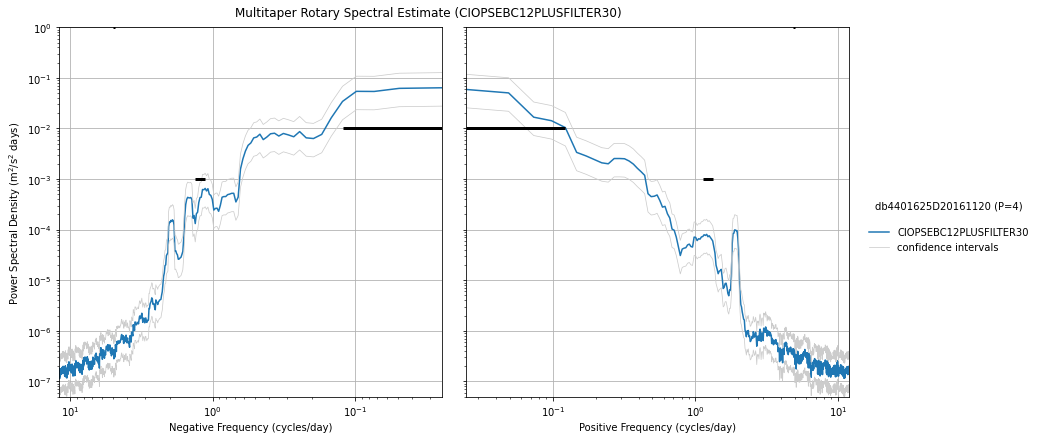

In [9]:
############################################################################
# Example with multiple datasets:
############################################################################
sampleid = 'db4401625D20161120'
datadict = process_datasets(ciopse_files)
datadict_filtered = process_datasets(ciopse_files_filter)
buoyids = datadict.keys()

for buoyid in buoyids:
    
    if sampleid not in buoyid:
        continue
    
    dcombine = concat_outputs([datadict[buoyid]['ds'], datadict_filtered[buoyid]['ds']])
    plot_multi_taper_with_sym_confidence_intervals(dcombine, outdir, P=4)
    
    # to run with a single dataset:
    #plot_multi_taper_with_sym_confidence_intervals(datadict[buoyid]['ds'], outdir, P=4)

### Plot periodogram

In [10]:
def periodogram_rotary_spectral_estimate(d, outdir):
    
    dt = (d.time[1] - d.time[0]).values / np.timedelta64(1,'D')
    d = d.dropna(dim='time')
    
    cvdict = create_cvdict(d)
    
    #fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    fig, axs = plt.subplots(1, len(cvdict.keys()), sharey=True, figsize=(14, 5))
    
    names = list(cvdict.keys())
    cvs = [cvdict[n] for n in names]
    axss = [axs[i] for i in range(0, len(names))]
     
    for name, cv, ax in zip(names, cvs, axss):
    
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            f, S = sg.periodogram(cv - np.mean(cv), fs=1 / dt) 
            
        # plot the positive side (note: ax.autoscale only works if we drop the first point)
        ax.semilogy(f[np.where(f >= 0)][1:], S[np.where(f >= 0)][1:], linewidth=0.75, label='Positive Frequencies')
        
        # plot negative side (note: ax.autoscale only works if we drop the first point)
        ax.semilogy(-f[np.where(f < 0)][1:], S[np.where(f < 0)][1:], linewidth=0.75, label='Negative Frequencies')
        
        ax.autoscale(enable=True, tight=True)
        
        # add reference lines 
        add_reference_lines(ax, d, cori_lats=['mean'])
        
        ax.set_xlabel('Frequency (cycles/day)')
        ax.set_title(name)
        #if ind == 0:
        if name == 'Observations':
            ax.set_ylabel('Power Spectral Density (m$^2$/s$^2$ days)')
            
    axs[len(names) - 1].legend(frameon=False, framealpha=0.4)   
    titlestr = 'periodogram_rotary_spectral_estimate (' + str(d.obs_buoyid) + ')'
    plt.suptitle(titlestr, y=.95)
    fig.tight_layout(h_pad=2, w_pad=2)
    outname = titlestr.replace(' ', '').replace('(', '_').replace(')', '') + '_' + str(len(names) - 1) + '.png'
    plt.savefig(os.path.join(outdir, outname))
    plt.show()
    plt.close()

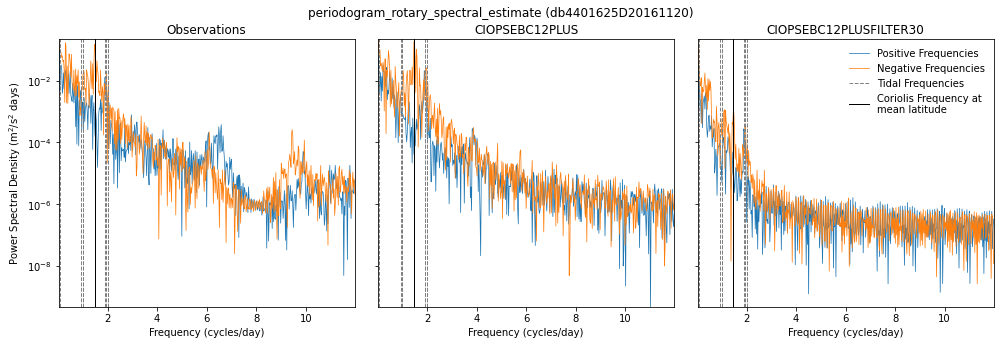

In [11]:
sampleid = 'db4401625D20161120'
datadict = process_datasets(ciopse_files)
datadict_filtered = process_datasets(ciopse_files_filter)
buoyids = datadict.keys()

for buoyid in buoyids:
    
    if sampleid not in buoyid:
        continue
    
    dcombine = concat_outputs([datadict[buoyid]['ds'], datadict_filtered[buoyid]['ds']])
    
    periodogram_rotary_spectral_estimate(dcombine, outdir)

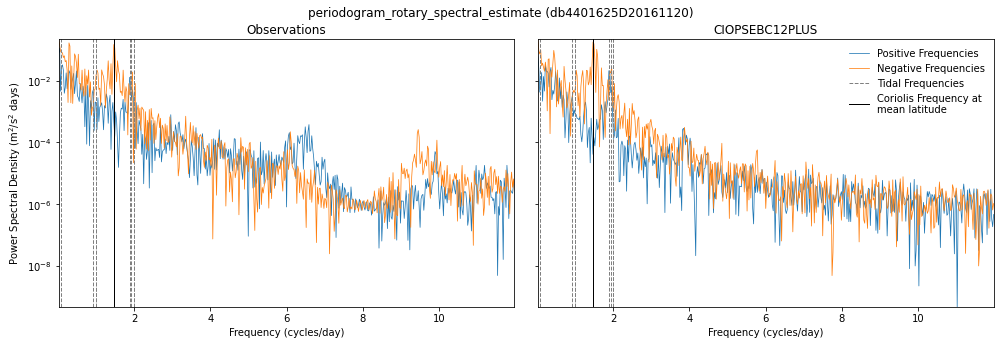

In [12]:
sampleid = 'db4401625D20161120'
datadict = process_datasets(ciopse_files)
buoyids = datadict.keys()

for buoyid in buoyids:
    
    if sampleid not in buoyid:
        continue
    
    periodogram_rotary_spectral_estimate(datadict[buoyid]['ds'], outdir)